In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

plt.style.use('fivethirtyeight')

plt.rcParams['axes.facecolor']='white'
plt.rcParams['axes.edgecolor']='white'
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

In [2]:
data = pd.read_csv('data.csv')
data.dropna(axis='index', subset=['pchembl_value'],inplace=True)
data.drop_duplicates(subset=['chembl_id'], keep=False, inplace=True)
data.set_index('chembl_id', inplace=True)
data

FileNotFoundError: [Errno 2] No such file or directory: 'data.csv'

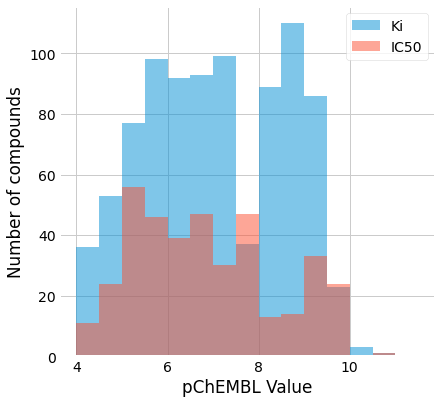

In [3]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
data[(data['standard_type']=='Ki') & (data['standard_relation']=='=')]['pchembl_value'].hist(ax=ax, alpha=0.5, label='Ki', bins=np.arange(4,12,0.5))
data[(data['standard_type']=='IC50') & (data['standard_relation']=='=')]['pchembl_value'].hist(ax=ax, alpha=0.5, label='IC50', bins=np.arange(4,12,0.5))
ax.set_xlabel('pChEMBL Value')
ax.set_ylabel('Number of compounds')
ax.legend(loc='best');

### Drawing molecules using RDKit

In [4]:
from rdkit import Chem

mols = {}
for chembl_id, row in data.iterrows():
    mols[chembl_id] = Chem.MolFromSmiles(row['canonical_smiles'])

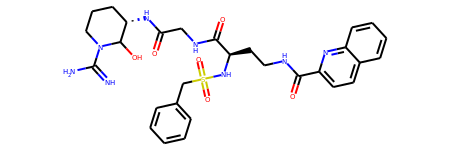

In [5]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

mols['CHEMBL117716']

### Descriptor calculation using RDKit

In [6]:
from rdkit.Chem import Descriptors

In [7]:
descriptors = {}

descriptors['n_atoms'] = {chembl_id: Descriptors.HeavyAtomCount(mol) for chembl_id, mol in mols.items()}
descriptors['rotatable_bonds'] = {chembl_id: Descriptors.NumRotatableBonds(mol) for chembl_id, mol in mols.items()}
descriptors['logp'] = {chembl_id: Descriptors.MolLogP(mol) for chembl_id, mol in mols.items()}
descriptors['molecular_weight'] = {chembl_id: Descriptors.ExactMolWt(mol) for chembl_id, mol in mols.items()}
descriptors['hb_donors'] = {chembl_id: Descriptors.NumHDonors(mol) for chembl_id, mol in mols.items()}
descriptors['hb_acceptors'] = {chembl_id: Descriptors.NumHAcceptors(mol) for chembl_id, mol in mols.items()}

descriptors = pd.DataFrame.from_dict(descriptors)

descriptors

,n_atoms,rotatable_bonds,logp,molecular_weight,hb_donors,hb_acceptors
CHEMBL117716,44,12,-0.24843,624.247852,7,8
CHEMBL117721,39,11,-2.39673,561.211801,7,9
CHEMBL331807,41,12,-1.69603,590.227116,8,9
CHEMBL323642,40,12,-1.40163,574.232202,7,8
CHEMBL47481,30,8,5.35750,395.211790,1,2
...,...,...,...,...,...,...
CHEMBL4172393,114,19,-3.22923,1622.737391,18,21
CHEMBL4164510,112,18,-3.74303,1596.721740,18,21
CHEMBL4175285,103,16,-7.37326,1484.665288,20,21
CHEMBL4167071,116,19,-4.09496,1650.743539,20,21


Let's compute the ligand efficiency for each of our molecules.

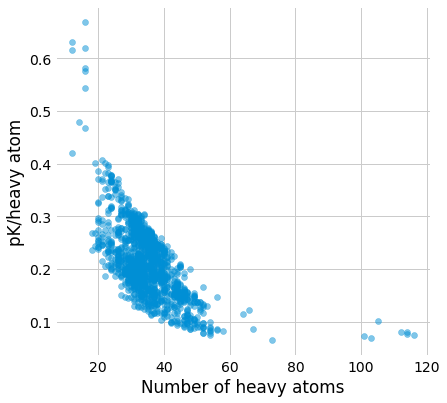

In [8]:
ligand_efficiency = data['pchembl_value'] / descriptors.loc[data.index]['n_atoms']

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(descriptors.loc[data.index]['n_atoms'], ligand_efficiency, alpha=0.5)
ax.set_xlabel('Number of heavy atoms')
ax.set_ylabel('pK/heavy atom');

Let's check how many of our molecules have Lipinski RO5 violations.

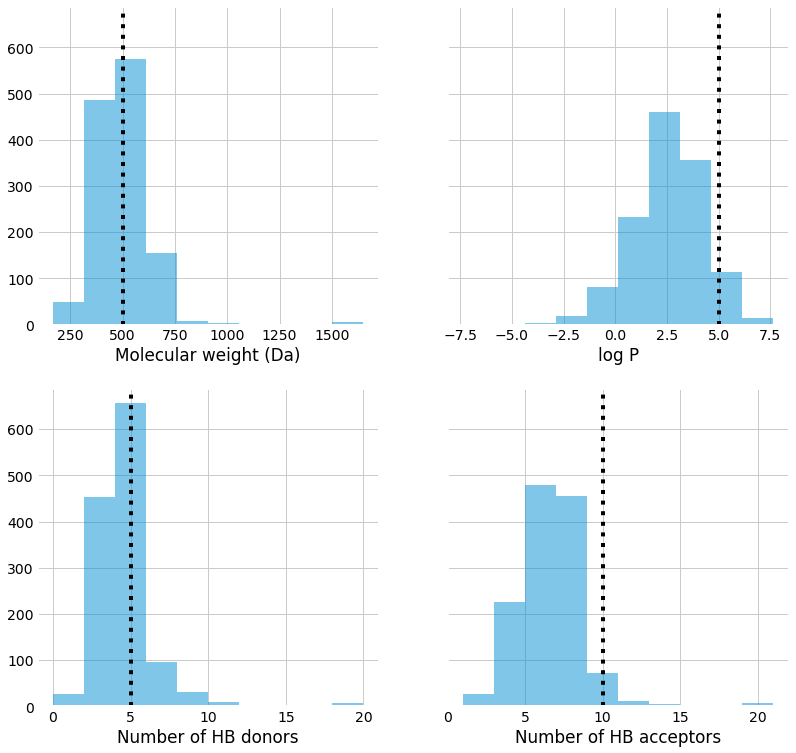

In [9]:
fig, axes = plt.subplots(2,2,figsize=(12,12), sharey=True)
axes = axes.flat
descriptors['molecular_weight'].hist(ax=axes[0], alpha=0.5)
axes[0].axvline(500, color='k', linestyle=':')
axes[0].set_xlabel('Molecular weight (Da)')
descriptors['logp'].hist(ax=axes[1], alpha=0.5)
axes[1].set_xlabel('log P')
axes[1].axvline(5, color='k', linestyle=':')
descriptors['hb_donors'].hist(ax=axes[2], alpha=0.5)
axes[2].set_xlabel('Number of HB donors')
axes[2].axvline(5, color='k', linestyle=':')
descriptors['hb_acceptors'].hist(ax=axes[3], alpha=0.5)
axes[3].set_xlabel('Number of HB acceptors')
axes[3].axvline(10, color='k', linestyle=':');